In [47]:
# import dependencies
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import time

In [68]:
# Summary|

# In this project, I use the phishing URL datasaet from UCI's repo as well as Prasad & Chandra (citation in the load_data method).
# The goal was to test how easily we can identify phishing url's, which if possible, would significantly help us
# protect people who are more vulnerable on the internet from malicious actors.
# The dataset is quite large with over 200k rows, but is quite clean and free of missing values.
# It comes with many columns that analyze various aspects of the URL. By using a random forest classifier, we demonstrate
# that predicting malicious websites is quite possible, although there's certainly still a small chance of both false positives
# and false negatives, as demonstrated lower in the report.

In [48]:
def load_data():
    # original data source: https://archive.ics.uci.edu/dataset/967/phiusiil+phishing+url+dataset
    # thanks to
    #    Prasad, A., & Chandra, S. (2023). 
    #    PhiUSIIL: A diverse security profile empowered phishing URL detection framework 
    #        based on similarity index and incremental learning. Computers & Security, 103545.
    #        doi: https://doi.org/10.1016/j.cose.2023.103545
    
    file_path = "PhiUSIIL_Phishing_URL_Dataset.csv"
    df = pd.read_csv(file_path)
    # drop filename because it's okay to drop according to source
    df.drop(['FILENAME'], axis=1, inplace=True)
    # drop URL, domain, and Title because it's unclear how they'd help, they're unique for each row.
    df.drop(['URL', 'Domain', 'Title'], axis=1, inplace=True)
    # encode TLD
    le = LabelEncoder()
    # Allison alluded to that in the post you linked, recommending use of the most frequent category as the reference when performing that type of VIF calculation.
    df_enc = le.fit_transform(df['TLD'].values)

    df_enc = pd.DataFrame(df_enc, columns=['TLD_encoded'])
    X = df.drop(['label', 'TLD'], axis=1)
    X = pd.concat([X, df_enc], axis=1)
    y = df['label']

    return X, y

X,y = load_data()

In [49]:
print(X.describe())

           URLLength   DomainLength     IsDomainIP  URLSimilarityIndex  \
count  235795.000000  235795.000000  235795.000000       235795.000000   
mean       34.573095      21.470396       0.002706           78.430778   
std        41.314153       9.150793       0.051946           28.976055   
min        13.000000       4.000000       0.000000            0.155574   
25%        23.000000      16.000000       0.000000           57.024793   
50%        27.000000      20.000000       0.000000          100.000000   
75%        34.000000      24.000000       0.000000          100.000000   
max      6097.000000     110.000000       1.000000          100.000000   

       CharContinuationRate  TLDLegitimateProb    URLCharProb      TLDLength  \
count         235795.000000      235795.000000  235795.000000  235795.000000   
mean               0.845508           0.260423       0.055747       2.764456   
std                0.216632           0.251628       0.010587       0.599739   
min          

In [50]:
print(X.dtypes)
print("Shape: {}".format(X.shape))

URLLength                       int64
DomainLength                    int64
IsDomainIP                      int64
URLSimilarityIndex            float64
CharContinuationRate          float64
TLDLegitimateProb             float64
URLCharProb                   float64
TLDLength                       int64
NoOfSubDomain                   int64
HasObfuscation                  int64
NoOfObfuscatedChar              int64
ObfuscationRatio              float64
NoOfLettersInURL                int64
LetterRatioInURL              float64
NoOfDegitsInURL                 int64
DegitRatioInURL               float64
NoOfEqualsInURL                 int64
NoOfQMarkInURL                  int64
NoOfAmpersandInURL              int64
NoOfOtherSpecialCharsInURL      int64
SpacialCharRatioInURL         float64
IsHTTPS                         int64
LineOfCode                      int64
LargestLineLength               int64
HasTitle                        int64
DomainTitleMatchScore         float64
URLTitleMatc

In [51]:
def show_vif(X, y):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data['VIF'] = [vif(X.values, i) for i in range(len(X.columns))]
    return vif_data

In [52]:
vif_results = show_vif(X, y)

In [53]:
print(vif_results.sort_values('VIF', axis = 0, ascending=False))

                       Feature          VIF
0                    URLLength  2853.412658
12            NoOfLettersInURL  1216.995586
14             NoOfDegitsInURL   149.871596
6                  URLCharProb    70.230330
3           URLSimilarityIndex    70.135014
13            LetterRatioInURL    57.906424
4         CharContinuationRate    51.503446
19  NoOfOtherSpecialCharsInURL    36.098239
25       DomainTitleMatchScore    34.169894
26          URLTitleMatchScore    33.973588
7                    TLDLength    28.355759
1                 DomainLength    22.913237
20       SpacialCharRatioInURL    15.864190
24                    HasTitle    12.194070
8                NoOfSubDomain    12.176399
21                     IsHTTPS     9.475388
50                 TLD_encoded     9.438973
16             NoOfEqualsInURL     9.195259
10          NoOfObfuscatedChar     7.438504
15             DegitRatioInURL     4.700925
29                IsResponsive     4.685495
36                HasSocialNet  

In [54]:
def drop_high_variance_columns(X, n, results):
    # make sure to not drop the categorical variables encoded
    # The variables with high VIFs are indicator (dummy) variables that represent a categorical variable with three or more categories. 
    # If the proportion of cases in the reference category is small, 
    # the indicator variables will necessarily have high VIFs, 
    # even if the categorical variable is not associated with other variables in the regression model.
    results = results.drop(50, axis = 0)
    results = results.sort_values('VIF', axis = 0)
    n_worst_parameters = list(results['Feature'][-n:])
    print("dropping the following {}".format(n_worst_parameters))
    return X.drop(n_worst_parameters, axis = 1)

In [55]:
params_to_drop = 18
X_reduced_vif = drop_high_variance_columns(X, params_to_drop, vif_results)

# this will be used for tracking efficiency by parameter count
parameter_count = len(X.columns)

# start out with manually changin the amount of parameters, and recording how long it took (I'll make a dict that auto adds new counts)
train_X, test_X, train_y, test_y = train_test_split(X_reduced_vif, y, test_size=0.2)

dropping the following ['NoOfObfuscatedChar', 'NoOfEqualsInURL', 'IsHTTPS', 'NoOfSubDomain', 'HasTitle', 'SpacialCharRatioInURL', 'DomainLength', 'TLDLength', 'URLTitleMatchScore', 'DomainTitleMatchScore', 'NoOfOtherSpecialCharsInURL', 'CharContinuationRate', 'LetterRatioInURL', 'URLSimilarityIndex', 'URLCharProb', 'NoOfDegitsInURL', 'NoOfLettersInURL', 'URLLength']


In [56]:
print("train_X has shape {}".format(train_X.shape))
print("test_X has shape {}".format(test_X.shape))
print("train_y has shape {}".format(train_y.shape))
print("test_y has shape {}".format(test_y.shape))

train_X has shape (188636, 33)
test_X has shape (47159, 33)
train_y has shape (188636,)
test_y has shape (47159,)


In [57]:
# svc = SVC(kernel='rbf', C=1, gamma = 3)
# svc.fit(train_X, train_y)

# SVM doesn't work, too many samples, and it increases nonlinearly with the sample count
# I was unable to finish a single rbf SVC, even with fixed params

In [58]:
# svc_parameter_train_times = {}
# C_range = np.logspace(-2, 5, 5, base=2)
# gamma_range = np.logspace(-2, 5, 5, base=2)
# param_grid = {"C": C_range, "gamma": gamma_range}

In [59]:
# Support Vector Classifier
# Time how long it takes with various parameters removed to make a case for the improvement due to VIF
# and show the test results due to different parameter usage.
# start_time = time.perf_counter()

# svc_pipeline = make_pipeline(StandardScaler(), GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid))
# svc_pipeline.fit(train_X, train_y)
# end_time = time.perf_counter()
# time_to_train = end_time - start_time

# svc_parameter_train_times["{}".format(train_X.columns):] = {"{} parameters".format(len(train_X.columns)): time_to_train}

In [60]:
# get the estimator out of the pipeline
# svc_clf = svc_pipeline.named_steps['gridsearchcv']

In [61]:
rf_parameter_train_times = {}
n_estimators_range = np.arange(1, 200, 10)
param_grid = {'n_estimators': n_estimators_range}

In [62]:
# Random Forest Classifier
# Time how long it takes with various parameters removed to make a case for the improvement due to VIF
# and show the test results due to different parameter usage.
start_time = time.perf_counter()
rfc_pipeline = make_pipeline(StandardScaler(), 
                             GridSearchCV(
                                RandomForestClassifier(max_depth=2),
                                 param_grid=param_grid,
                                 scoring=['accuracy', 'roc_auc'],
                                 refit = 'accuracy'
                             )
                            )
rfc_pipeline.fit(train_X, train_y)
end_time = time.perf_counter()
time_to_train = end_time - start_time

rf_parameter_train_times["{}".format(list(train_X.columns))] = {"{} parameters".format(len(train_X.columns)): time_to_train}

In [63]:
# get the estimator out of the pipeline
rfc_clf = rfc_pipeline.named_steps['gridsearchcv']

In [64]:
# print(svc_parameter_train_times)
print(rf_parameter_train_times)

{"['IsDomainIP', 'TLDLegitimateProb', 'HasObfuscation', 'ObfuscationRatio', 'DegitRatioInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'LineOfCode', 'LargestLineLength', 'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'TLD_encoded']": {'33 parameters': 421.779399999883}}


In [65]:
result_df = pd.DataFrame(rfc_clf.cv_results_)

In [66]:
result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,...,std_test_accuracy,rank_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,0.077217,0.003545,0.018404,0.000490,1,{'n_estimators': 1},0.929946,0.968935,0.946219,0.967318,...,0.014667,20,0.946643,0.978857,0.964374,0.979517,0.972133,0.968305,0.012136,20
1,0.495312,0.014936,0.044810,0.000749,11,{'n_estimators': 11},0.984759,0.985952,0.983566,0.981711,...,0.002170,19,0.998683,0.998768,0.998264,0.997631,0.998041,0.998277,0.000419,19
2,0.901350,0.012981,0.071039,0.001535,21,{'n_estimators': 21},0.983328,0.982559,0.988178,0.983858,...,0.001972,18,0.998787,0.998831,0.999264,0.999156,0.998799,0.998968,0.000202,17
3,1.281585,0.069112,0.096822,0.001167,31,{'n_estimators': 31},0.987781,0.984653,0.984441,0.986323,...,0.001255,16,0.999098,0.998840,0.998779,0.998907,0.998973,0.998919,0.000110,18
4,1.644771,0.034327,0.122428,0.001356,41,{'n_estimators': 41},0.988152,0.984043,0.987171,0.987144,...,0.001442,14,0.999317,0.998812,0.999153,0.999167,0.999014,0.999092,0.000170,14
5,2.039821,0.017902,0.148245,0.000395,51,{'n_estimators': 51},0.988179,0.975720,0.983858,0.988337,...,0.004882,17,0.999137,0.998825,0.998946,0.999143,0.999198,0.999050,0.000141,16
6,2.465321,0.019727,0.173452,0.001353,61,{'n_estimators': 61},0.987198,0.985952,0.985475,0.985183,...,0.000876,15,0.999130,0.999046,0.999028,0.999151,0.999098,0.999091,0.000047,15
7,2.817890,0.026358,0.200046,0.000633,71,{'n_estimators': 71},0.988656,0.984679,0.985713,0.987595,...,0.001573,11,0.999309,0.998966,0.999001,0.999293,0.999178,0.999150,0.000143,7
8,3.243164,0.076838,0.229464,0.004714,81,{'n_estimators': 81},0.988576,0.986217,0.984891,0.987595,...,0.001272,13,0.999283,0.999092,0.998984,0.999182,0.998962,0.999101,0.000121,13
9,3.636919,0.028936,0.252458,0.001856,91,{'n_estimators': 91},0.988258,0.987065,0.986349,0.988046,...,0.000690,9,0.999202,0.999154,0.999027,0.999233,0.999110,0.999145,0.000072,9


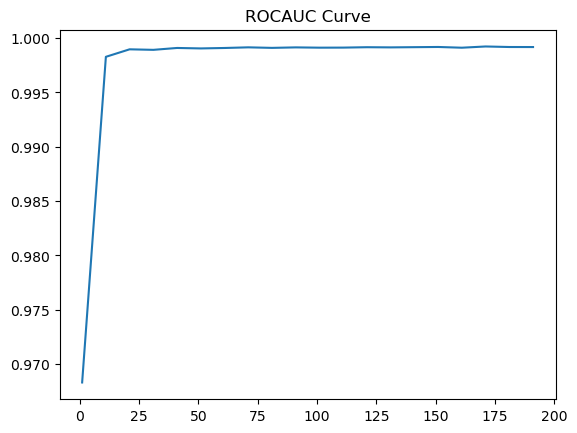

In [70]:
# plot roc_auc score
plt.title("ROCAUC Curve")
plt.plot(result_df['param_n_estimators'], result_df['mean_test_roc_auc'])

In [71]:
# y_pred_svc = svc_pipeline.predict(test_X)
y_pred_rf = rfc_pipeline.predict(test_X)

In [72]:
# test results
# svc_test_results = accuracy_score(test_y, y_pred_svc)
print("The accuracy score for our classifier is {}".format(accuracy_score(test_y, y_pred_rf)))

The accuracy score for our classifier is 0.9868105769842448


In [73]:
# print("SVC Classification Results")
# print(classification_report(y_true, y_pred_svc))

In [74]:
print("Random Forest Classification Results")
print("The ideal number of trees was about {}".format(rfc_clf.best_params_))
print(classification_report(test_y, y_pred_rf))

Random Forest Classification Results
The ideal number of trees was about {'n_estimators': 181}
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     20332
           1       0.98      0.99      0.99     26827

    accuracy                           0.99     47159
   macro avg       0.99      0.99      0.99     47159
weighted avg       0.99      0.99      0.99     47159



Text(0, 0.5, 'Training time (sec)')

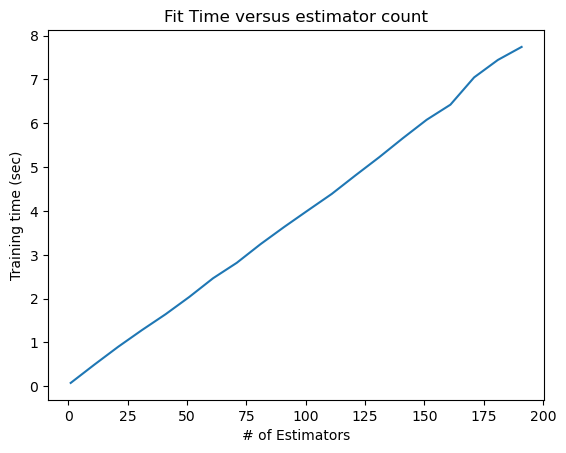

In [75]:
plt.plot(result_df['param_n_estimators'], result_df['mean_fit_time'], label='Train Time')
plt.title('Fit Time versus estimator count')
plt.xlabel('# of Estimators')
plt.ylabel("Training time (sec)")

Text(0.5, 1.0, 'Cross Validation Results versus N estimators')

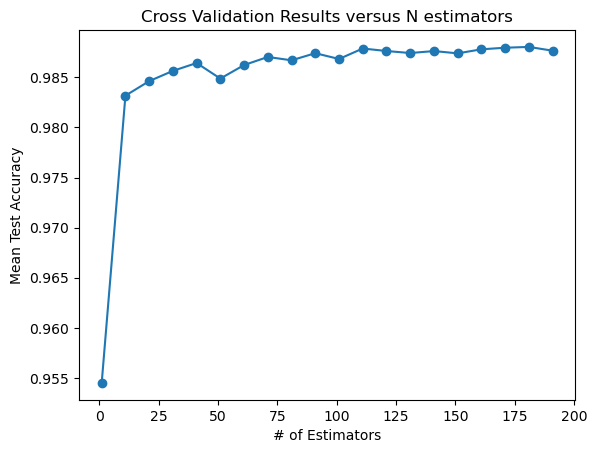

In [76]:
plt.plot(result_df['param_n_estimators'], result_df['mean_test_accuracy'])
plt.scatter(result_df['param_n_estimators'], result_df['mean_test_accuracy'])
plt.xlabel('# of Estimators')
plt.ylabel('Mean Test Accuracy')
plt.title('Cross Validation Results versus N estimators')